# 0 - Modules

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import unicodedata

import seaborn as sns


---

# 1 - Data Lecture

In our main dataset (birthPlaceRegion_sex), the 'Birth_Place_Region' column cointains the following nationalities:

Africa
- Eastern Africa
- Middle Africa
- Northern Africa
- Southern Africa
- Western Africa
America
- Caribbean
- Central America
- Northern America
- South America

Asia
- Central Asia
- Eastern Asia
- Southern Asia 
- South-Eastern Asia
- Western Asia

Europe    
- Eastern Europe
- Northern Europe
- Southern Europe
- Western Europe

Oceania
- Australia and New Zealand
- Melanesia

Others
- Not available

Nevertheless, my team have decided to group them in the following way:

region_map = { 
    
    'Eastern Africa': 'Africa',
    'Middle Africa': 'Africa',
    'Southern Africa': 'Africa',
    'Western Africa': 'Africa',

    'Northern Africa': 'MENA',
    'Western Asia': 'MENA',

    'Caribbean': 'Latin America',
    'Central America': 'Latin America',
    'South America': 'Latin America',

    'Eastern Europe': 'Europe',
    'Northern Europe': 'Europe',
    'Southern Europe': 'Europe',
    'Western Europe': 'Europe',

    'Australia and New Zealand': 'NA-AUS-NZ',
    'Northern America': 'NA-AUS-NZ',
    'Melanesia': 'NA-AUS-NZ',

    'Eastern Asia': 'Asia',
    'South-Eastern Asia': 'Asia',

    'Southern Asia': 'Asia',    
}

Finally, one important thing that we need to notice is that the Spanish population is included in 'Europe' as well, but since we are studying immigration, we will separate it from the rest of European nationalities. Thus, we will create a new region called 'Spain' for that purpose, ing it from 'Europe'. 

Let's notice that we are able to do that because of the data of other dataset (birthPlace_spain_v_outside) for the same years. So, we will group the labels of this dataset as follows:

spanish_map = {

    'City of Barcelona': 'Spain',
    'Rest of Catalonia': 'Spain',
    'Rest of Spain': 'Spain',

    'Rest of European Union': 'Immigrant',
    'Rest of World': 'Immigrant',
}

and then do the ion mentioned before to obtain the final DataFrame which we will be using.

In [23]:
def neighborhood_lecture_groups(year, level = 'Neighborhood'): # it returns a DataFrame with the number of people per grouped region

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Birth Place DataFrame)

    data_dir = '../data/birthPlaceRegion/'
    file = f'{year}_birthPlaceRegion_sex.csv'
    df = pd.read_csv(data_dir + file)

    # --- CLEANING ---
    
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip() # ensure Birth_Place_Region is string and strip whitespace 

    #  --- IGNORE SEX ---

    df = df.groupby([level, 'Birth_Place_Region'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Northern Africa': 'MENA',
        'Western Asia': 'MENA',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',

        'Southern Asia': 'Asia',    
    }

    df['Group'] = df['Birth_Place_Region'].map(region_map).fillna('Other') # map regions to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Spanish vs Immigrant DataFrame)

    data_dir2 = '../data/birthPlace_spain_v_outside/'
    file2 = f'{year}_birthPlace_spain_v_outside.csv'
    df2 = pd.read_csv(data_dir2 + file2)

    # --- CLEANING ---

    df2['Value'] = pd.to_numeric(df2['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df2['Birth_Place'] = df2['Birth_Place'].astype(str).str.strip() # ensure Birth_Place is string, strip whitespace

    # --- IGNORE SEX ---

    df2 = df2.groupby([level, 'Birth_Place'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    spanish_map = {
        'City of Barcelona': 'Spain',
        'Rest of Catalonia': 'Spain',
        'Rest of Spain': 'Spain',

        'Rest of European Union': 'Immigrant',
        'Rest of World': 'Immigrant',
    }

    df2['Group'] = df2['Birth_Place'].map(spanish_map).fillna('Other') # map birth places to groups, fill unmapped with 'Other'

    # ------------------------------------------------------------------------------------------------

    # --- SUBTRACT SPANISH FROM ORIGINAL DATAFRAME  --- (particularly, European Group)

    ## Total Spanish population per neighborhood

    spanish_df = df2[df2['Group'] == 'Spain'].groupby(level)['Value'].sum().reset_index() # get total Spanish counts per neighborhood
    spanish_df.rename(columns = {'Value': 'Spain_Value'}, inplace = True) # rename for clarity and ease to subtract

    ## Merge Spanish counts into df

    df = df.merge(spanish_df, on = level, how = 'left') 
    df['Spain_Value'] = df['Spain_Value'].fillna(0) # fill NaN with 0 

    # Subtract Spanish from Europe group

    mask_europe = df['Group'] == 'Europe' 
    df.loc[mask_europe, 'Value'] = df.loc[mask_europe, 'Value'] - df.loc[mask_europe, 'Spain_Value'] 

    # Avoid negative values due to imperfect grouping

    df['Value'] = df['Value'].clip(lower = 0) # just in case

    # --- ADD SPAIN AS A GROUP ---

    spain_group = spanish_df.copy() 
    spain_group['Group'] = 'Spain'
    spain_group.rename(columns = {'Spain_Value': 'Value'}, inplace = True) # rename to match df format

    # Append Spain group to df

    df = pd.concat([df[[level, 'Group', 'Value']], spain_group[[level, 'Group', 'Value']]], ignore_index = True)

    # ------------------------------------------------------------------------------------------------
    
    absolute_groups = df.groupby([level, 'Group'], as_index = False)['Value'].sum() # final grouping

    return absolute_groups


def neighborhood_group_dictionary(year, level = 'Neighborhood'): # same as above but in dictionary format with year as input

    # --- LOAD AND GROUP DATA ---

    df = neighborhood_lecture_groups(year, level = level)
    
    # --- CLEANING ---

    df[level] = df[level].astype(str).str.strip().str.lower() # ensure level column is string and strip whitespace
    df['Group'] = df['Group'].astype(str).str.strip().str.lower() # ensure Group column is string and strip whitespace
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert Value to numeric, coerce errors to NaN, fill NaN with 0, convert to int

    # --- CREATE DICTIONARY ---

    neighborhood_dict = {}
    for neighborhood in df[level].unique():
        sub_df = df[df[level] == neighborhood].drop(columns = [level])
        neighborhood_dict[neighborhood] = sub_df.reset_index(drop = True)

    return neighborhood_dict


In [24]:
# Test

data = neighborhood_lecture_groups(2022)
display(data)

,Neighborhood,Group,Value
0,Baró de Viver,Africa,11
1,Baró de Viver,Asia,85
2,Baró de Viver,Europe,16
3,Baró de Viver,Latin America,298
4,Baró de Viver,MENA,121
...,...,...,...
571,les Tres Torres,Latin America,972
572,les Tres Torres,MENA,193
573,les Tres Torres,NA-AUS-NZ,150
574,les Tres Torres,Other,5


---

# 2 - Diversity Calculation

## QUESTION: What is the diversity of each neighborhood in Barcelona?

## PROCEDURE:

We are going to use the Simpsons Diversity Index to calculate the diversity of nationalities in each neighborhood, which is defined as:

$$ D = 1 - \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

Where:

- $ D $ is the diversity index
- $ S $ is the total number of different nationalities
- $ n_i $ is the number of individuals of nationality $ i $
- $ N $ is the total number of individuals

Thus, we are taking an ecological approach to measure diversity since this index is widely used in ecology to quantify biodiversity in a community.

In [25]:
# Simpson's Diversity Index Calculation

def simpsons_diversity_index(df): # it returns the simpsons diversity index given a dataframe

    N = df['Value'].sum()

    if N == 0:
        return 0  # avoid division by zero (just in case but not expected to happen)
    
    sum_pi_squared = sum((count / N) ** 2 for count in df['Value'])
    D = 1 - sum_pi_squared

    return D


Now, we need a function that, giving a year, read the correponding data and calculate the diversity index for each neighborhood.

In [26]:
def compute_neighborhood_diversity(lecture_function, year): # it returns a dataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df_neighborhood = lecture_function(year)  # returns dict: neighborhood -> DataFrame
    
    # --- COMPUTE SIMPSON'S DIVERSITY INDEX ---

    diversity_results = {} # initialize empty dictionary to store results

    for label_neighborhood, df in df_neighborhood.items(): # it  works over all the neighborhoods separately (different dataframes)
        diversity_index = simpsons_diversity_index(df)
        diversity_results[label_neighborhood] = diversity_index
    
    # --- CONVERT TO DATAFRAME ---

    diversity_df = pd.DataFrame(
        list(diversity_results.items()), 
        columns=['Neighborhood', 'Simpsons_Diversity_Index']
    )
    
    # --- SORT DESCENDING --- (to better visualize the most and least diverse neighborhoods)

    diversity_df = diversity_df.sort_values(
        by = 'Simpsons_Diversity_Index', 
        ascending = False
    ).reset_index(drop = True)
    
    return diversity_df


To better visualize the diversity, we will create a color map that assigns colors to diversity index values.

In [27]:

def prepare_gdf(lecture_function, year): # it returns a geodataframe with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df = compute_neighborhood_diversity(lecture_function, year)  # columns: Neighborhood, Simpsons_Diversity_Index

    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---
    
    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip().str.lower() # ensure Neighborhood is string and strip whitespace and convert to lowercase
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---
    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---
    
    merged_gdf = gdf.merge(df, on='Neighborhood', how='left')
    
    # --- CLEANING ---

    merged_gdf['Simpsons_Diversity_Index'] = merged_gdf['Simpsons_Diversity_Index'].fillna(0) # fill missing diversity values with 0

    return merged_gdf


def plot_simpsons_index(lecture_function, year, ax): # it plots the diversity index per neighborhood given a year
    global vmin, vmax

    gdf = prepare_gdf(lecture_function, year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin = vmin, vmax = vmax)

    #  --- PLOTTING ---

    gdf.plot(column = 'Simpsons_Diversity_Index',
             ax = ax,
             cmap = 'cividis',
             norm = norm,
             linewidth = 0.4,
             edgecolor = 'black')

    ax.axis('off')

    # --- CREATE COLORBAR ---

    sm = ScalarMappable(cmap = 'cividis', norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])  

    return sm 


In [28]:
# # Test

# df_merged = prepare_gdf(2022)
# display(df_merged)

## RESULTS:

In [29]:
# CSV selection

lecture_function = neighborhood_group_dictionary
year = 2025

In [30]:
diversity_df = compute_neighborhood_diversity(lecture_function, year)
display(diversity_df)

,Neighborhood,Simpsons_Diversity_Index
0,el barri gòtic,0.751666
1,el raval,0.720647
2,"sant pere, santa caterina i la ribera",0.685595
3,el besòs i el maresme,0.657706
4,la barceloneta,0.642869
...,...,...
68,can peguera,0.288808
69,"vallvidrera, el tibidabo i les planes",0.278606
70,les tres torres,0.268172
71,la font d'en fargues,0.244937


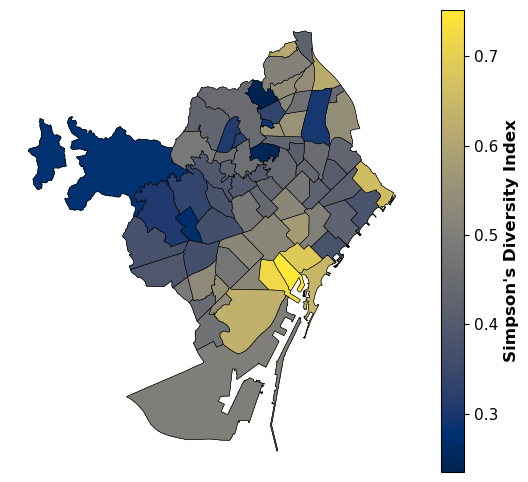

In [31]:
# Prepare GeoDataFrame

df = prepare_gdf(lecture_function, year)

# Normalization limits

vmin = df['Simpsons_Diversity_Index'].min()
vmax = df['Simpsons_Diversity_Index'].max()

# Map

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plot_simpsons_index(lecture_function, year, ax)

# Colorbar

mappable = plot_simpsons_index(lecture_function, year, ax)

cbar = plt.colorbar(
    mappable,
    ax = ax,
    label = "Simpson's Diversity Index"
)

cbar.set_label(
    "Simpson's Diversity Index",
    fontsize = 12,
    fontweight = "bold"
)

cbar.ax.tick_params(labelsize = 11)


### EXTRA: time evolution of diversity in neighborhoods between 1999 and 2025

In [32]:
def df_difference(lecture_function,initial_year, final_year): # it returns a geodataframe with the difference in diversity index between two years

    # --- LOAD INITIAL AND FINAL DATA ---

    df_initial = prepare_gdf(lecture_function, initial_year)[['Neighborhood', 'Simpsons_Diversity_Index']]
    df_final = prepare_gdf(lecture_function, final_year)[['Neighborhood', 'Simpsons_Diversity_Index']]

    # --- COMPUTE DIFFERENCE --- (in Simpson's Diversity Index)

    df_diff = df_final.copy()
    df_diff['Diversity_difference'] = df_final['Simpsons_Diversity_Index'] - df_initial['Simpsons_Diversity_Index']
    df_diff = df_diff[['Neighborhood', 'Diversity_difference']]

    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].str.strip().str.lower() # ensure Neighborhood is string and strip whitespace and convert to lowercase
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(
        geometry_df,
        geometry='Geometry_etrs89',
        crs='EPSG:25831'
    )

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---

    gdf_diff = pd.merge(gdf, df_diff, on = 'Neighborhood', how = 'left')

    return gdf_diff


def plot_difference(lecture_function,ax, initial_year, final_year, cmap='inferno'):

    # --- LOAD DIFFERENCE DATA ---

    gdf_diff = df_difference(lecture_function, initial_year, final_year)

    # --- NORMALIZATION ---

    diff_vmax = gdf_diff['Diversity_difference'].max()
    diff_vmin = gdf_diff['Diversity_difference'].min()
    norm = Normalize(vmin = diff_vmin, vmax = diff_vmax)

    # --- MAP ---
    gdf_diff.plot(
        column = 'Diversity_difference',
        ax = ax,
        cmap = cmap,
        norm = norm,
        linewidth = 0.4,
        edgecolor = 'black'
    )

    ax.axis('off')
    
    # --- COLORBAR ---
    
    sm = ScalarMappable(cmap = cmap, norm = norm) # creates scalar mappable for colorbar
    sm.set_array([])

    return sm



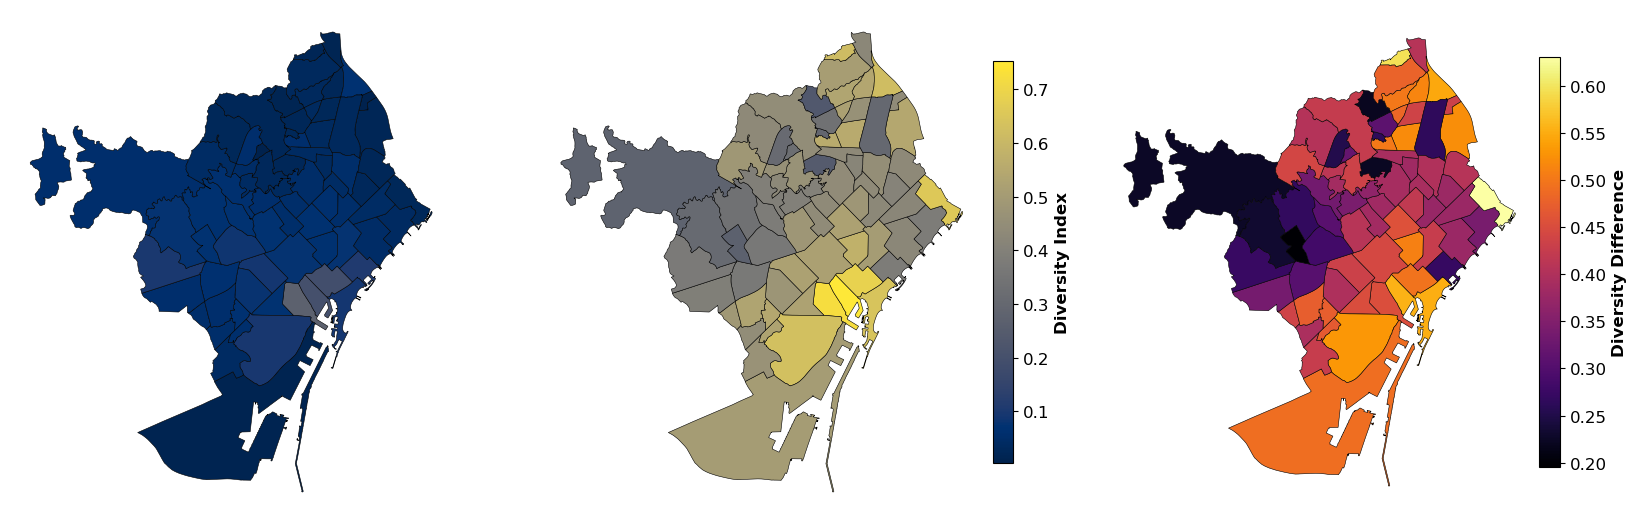

In [33]:
# CSV selection

years = [1999, 2025]

lecture_function = neighborhood_group_dictionary

# DataFrame

df_years = {year: prepare_gdf(lecture_function, year) for year in years}  

# Maps for each year with a common color scale

vmin = min(df_years[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax = max(df_years[year]['Simpsons_Diversity_Index'].max() for year in years)

fig, axes = plt.subplots(1, len(years)+1, figsize = (20, 10))
mappables = []

for ax, year in zip(axes, years):
    mappable = plot_simpsons_index(lecture_function, year, ax)
    mappables.append(mappable)  
    
# Colorbar for rent per capita

cbar = fig.colorbar(mappables[0], ax=axes[:-1], orientation = 'vertical', fraction = 0.02, pad = 0.01)
cbar.ax.tick_params(labelsize = 12)
cbar.set_label('Diversity Index', fontsize = 12, weight = 'bold')

# Map for the difference between the two years

mappable_diff = plot_difference(lecture_function, axes[-1], years[0], years[1])

# Colorbar for rent difference

cbar_diff = fig.colorbar(mappable_diff, ax = axes[-1], orientation = 'vertical', fraction = 0.045, pad = 0.01)
cbar_diff.ax.tick_params(labelsize = 12)
cbar_diff.set_label('Diversity Difference', fontsize = 12, weight = 'bold')
plt.show()



---

# 3 - Similarity between neighborhoods

## QUESTION: Giving some neighborhoods that we know are (not) diverse, how similar are them culturally taking into account the nationalities present in each neighborhood (percentage)?

## PROCEDURE:

We are going to use the cosine similarity method to calculate how similar the neighborhoods are, culturally speaking. That means that we have to take into account the nationality distribution in each neighborhood, not only the diversity index.

In order to do that, we will create a vector for each neighborhood, and in the overall, a matrix where:

- Rows -> Neighborhoods
- Columns -> Nationalities
- Values -> Percentage of each nationality 


In [34]:
def nationality_proportion_matrix(lecture_function, year, neighborhood_selection): # it returns a matrix with the nationality proportions per neighborhood

    # --- LOAD DATA ---

    df = lecture_function(year)

    ##  Keep only selected neighborhoods

    df = df[df['Neighborhood'].isin(neighborhood_selection)]

    # --- PIVOT TO MATRIX --- (to have neighborhoods as rows and groups as columns)

    matrix = df.pivot(index = 'Neighborhood',
                      columns = 'Group',
                      values = 'Value').fillna(0)

    # --- CONVERT TO PROPORTIONS --- (to have proportions instead of absolute counts)

    matrix = matrix.div(matrix.sum(axis=1), axis=0)

    return matrix

## RESULTS:

### Top 5 most diverse neighborhoods

In [35]:
lecture_function = neighborhood_lecture_groups

neighborhood_selection = ['el Barri Gòtic', 'el Raval', 'Sant Pere, Santa Caterina i la Ribera', 'el Besòs i el Maresme', 'Ciutat Meridiana']

matrix = nationality_proportion_matrix(lecture_function, 2025, neighborhood_selection)
display(matrix)

Group,Africa,Asia,Europe,Latin America,MENA,NA-AUS-NZ,Other,Spain
Neighborhood,,,,,,,,
Ciutat Meridiana,0.028427,0.068622,0.002716,0.305812,0.064548,0.000000,0.000000,0.529875
"Sant Pere, Santa Caterina i la Ribera",0.010683,0.077205,0.068793,0.262425,0.068483,0.031945,0.001909,0.478557
el Barri Gòtic,0.016502,0.347892,0.038518,0.207188,0.101273,0.018684,0.001587,0.268357
el Besòs i el Maresme,0.021653,0.189448,0.009589,0.203368,0.061316,0.002372,0.001650,0.510603
el Raval,0.008774,0.320705,0.034534,0.178527,0.073023,0.011454,0.001642,0.371340


Now it is time to compute the cosine similarity matrix. Lets remember the formula:

$$ \text{cosine\_similarity}(A, B) = \frac{A \cdot B}{||A|| \cdot ||B||} $$

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix

cos_sim = cosine_similarity(matrix.values)

# Convert to DataFrame for better readability

cos_sim_df = pd.DataFrame(
    cos_sim,
    index = matrix.index,
    columns = matrix.index
)

display(cos_sim_df)

Neighborhood,Ciutat Meridiana,"Sant Pere, Santa Caterina i la Ribera",el Barri Gòtic,el Besòs i el Maresme,el Raval
Neighborhood,,,,,
Ciutat Meridiana,1.000000,0.990163,0.766005,0.966376,0.850111
"Sant Pere, Santa Caterina i la Ribera",0.990163,1.000000,0.787391,0.967883,0.867714
el Barri Gòtic,0.766005,0.787391,1.000000,0.864507,0.976879
el Besòs i el Maresme,0.966376,0.967883,0.864507,1.000000,0.943322
el Raval,0.850111,0.867714,0.976879,0.943322,1.000000


A nice way to visualize the similarity matrix is through a cluster heatmap.

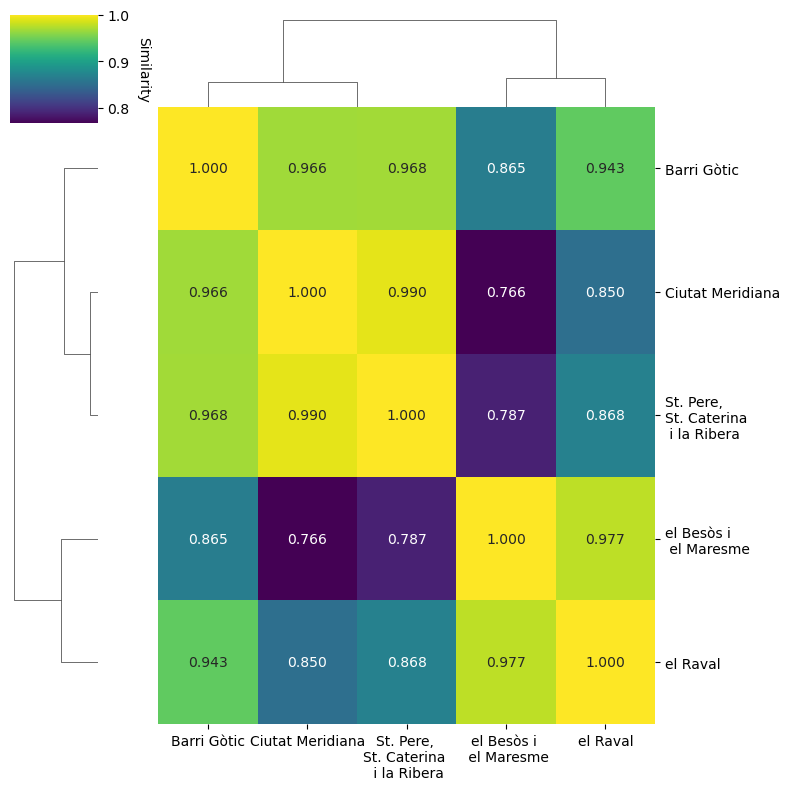

In [37]:
# Readability improvements

cos_sim_df_short = cos_sim_df.copy()
cos_sim_df_short.columns = ['Ciutat Meridiana', 'St. Pere, \nSt. Caterina \n i la Ribera', 'el Besòs i \n el Maresme', 'Barri Gòtic', 'el Raval']
cos_sim_df_short.index = ['Ciutat Meridiana', 'St. Pere, \nSt. Caterina \n i la Ribera', 'el Besòs i \n el Maresme', 'Barri Gòtic', 'el Raval']

# Clustermap with adjusted color scale limits

g = sns.clustermap(cos_sim_df_short,
                   annot = True,
                   fmt = '.3f',
                   cmap = 'viridis',
                   center = None,  # Remove center since your data isn't centered around 0
                   vmin = cos_sim_df_short.values.min(),  # Minimum data value
                   vmax = cos_sim_df_short.values.max(),  # Maximum data value
                   figsize = (8, 8),
                   dendrogram_ratio = 0.15,
                   cbar_pos = (0.9, 0.8, 0.03, 0.18))

# Improve label readability

plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha = 'center')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation = 0)

g.ax_row_dendrogram.set_position([0.02, 0.55, 0.01, 0.0])    # [left, bottom, width, height]
g.ax_col_dendrogram.set_position([0.95, 0.9, 0.01, 0.0])     # [left, bottom, width, height]

# Colorbar label

g.ax_cbar.set_ylabel('Similarity', rotation = 270, labelpad = 15)

plt.tight_layout()
plt.show()

Complementary graphic

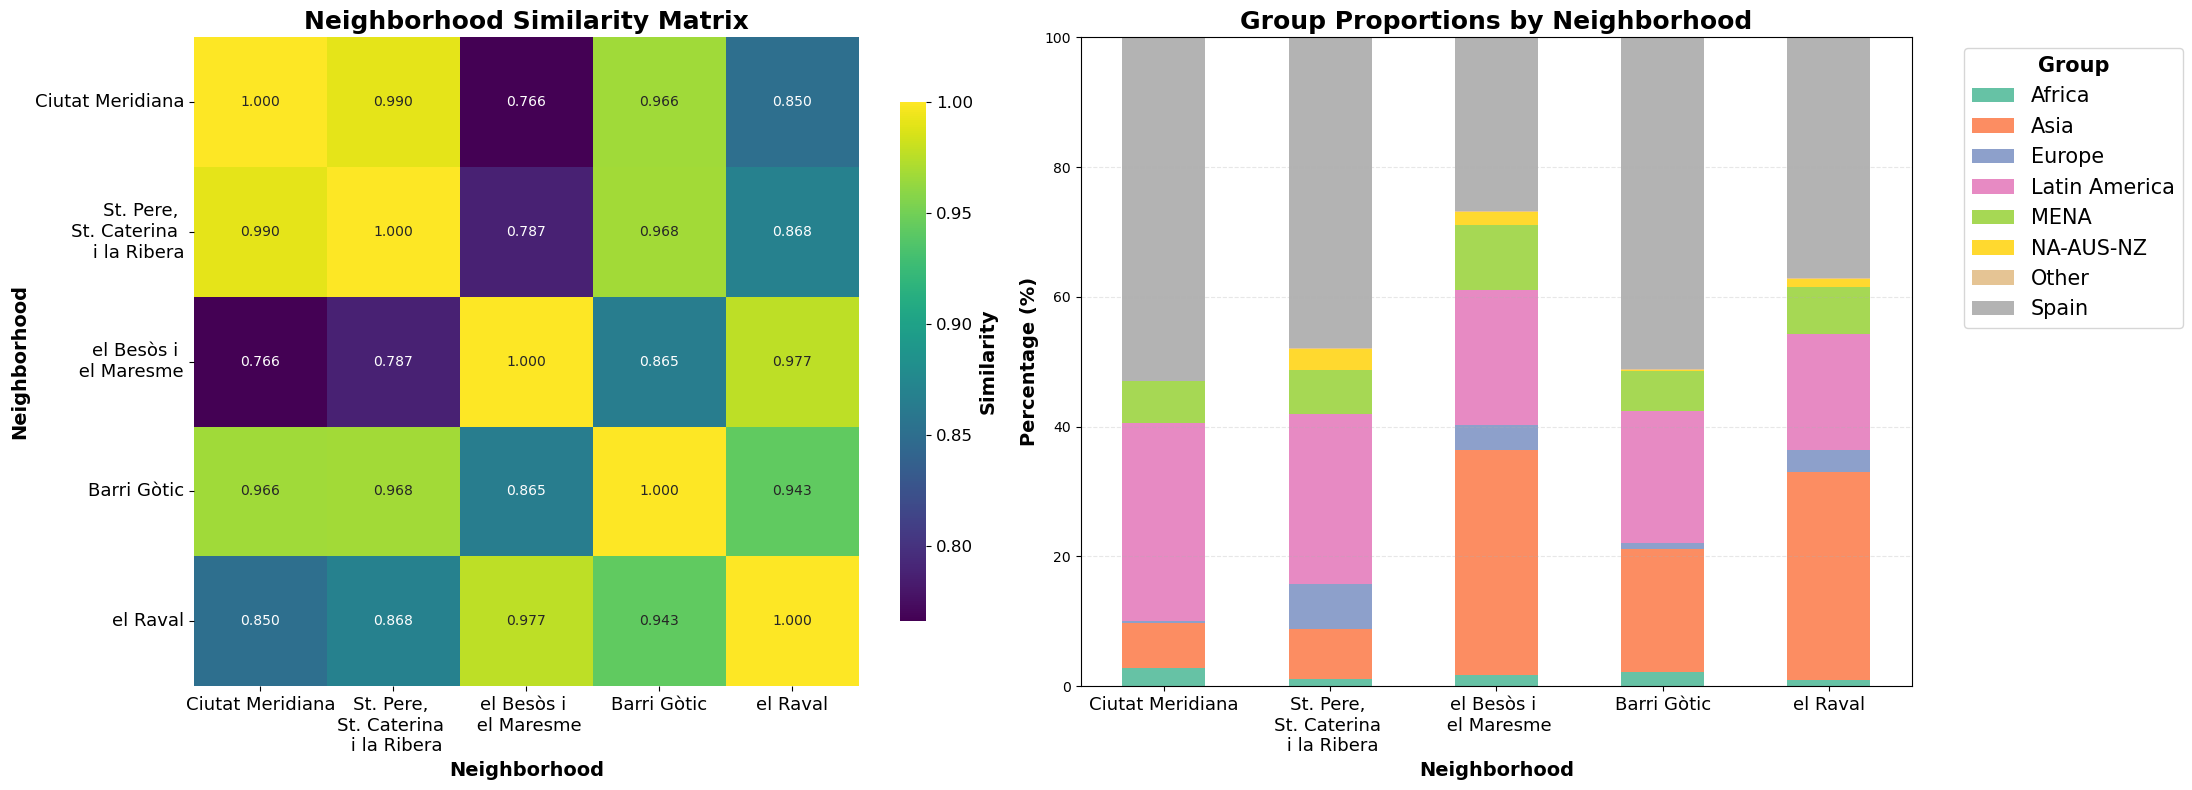

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# --- HEAT MAP (no clustering) --- (clustering complicates the plotting)

## Labels for better readability

cos_sim_df_short = cos_sim_df.copy()
cos_sim_df_short.columns = ['Ciutat Meridiana', 'St. Pere, \nSt. Caterina \n i la Ribera', 'el Besòs i \n el Maresme', 'Barri Gòtic', 'el Raval']
cos_sim_df_short.index = ['Ciutat Meridiana', 'St. Pere, \nSt. Caterina \n i la Ribera', 'el Besòs i \n el Maresme', 'Barri Gòtic', 'el Raval']

## Heatmap

heatmap = sns.heatmap(cos_sim_df_short, 
            annot = True, 
            fmt = '.3f', 
            cmap = 'viridis', 
            vmin = cos_sim_df_short.values.min(),
            vmax = cos_sim_df_short.values.max(),
            ax = ax1,
            cbar_kws = {'label': 'Similarity', 'shrink': 0.8})

## Colorbar

cbar = heatmap.collections[0].colorbar
cbar.set_label('Similarity', size = 14, weight='bold')
cbar.ax.tick_params(labelsize = 12)

## Title

ax1.set_title('Neighborhood Similarity Matrix', fontsize = 18, fontweight = 'bold')

## x-axis labels

ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 0, ha = 'center', fontsize = 13)
ax1.set_xlabel('Neighborhood', fontsize = 14, fontweight = 'bold')

## y-axis labels

ax1.set_yticklabels(ax1.get_yticklabels(), rotation = 0, ha = 'right', fontsize = 13) 
ax1.set_ylabel('Neighborhood', fontsize = 14, fontweight = 'bold')

# --- RIGHT: STACKED BAR CHART ---

## Load data

df = neighborhood_lecture_groups(2025)

filtered_df = df[df['Neighborhood'].isin(neighborhood_selection)]

pivot_df = filtered_df.pivot(index = 'Neighborhood', columns = 'Group', values = 'Value').fillna(0)
percentage_df = pivot_df.div(pivot_df.sum(axis = 1), axis = 0) * 100

## Stacked bar chart

bars = percentage_df.plot(kind = 'bar', stacked = True, ax = ax2, legend = True, cmap = "Set2")

## Title

ax2.set_title('Group Proportions by Neighborhood', fontsize = 18, fontweight = 'bold')
## y-axis labels

ax2.set_ylabel('Percentage (%)', fontsize = 14, fontweight = 'bold')

## x-axis labels

ax2.set_xlabel('Neighborhood', fontsize = 14, fontweight = 'bold')
ax2.set_xticklabels(['Ciutat Meridiana', 'St. Pere, \nSt. Caterina \n i la Ribera', 'el Besòs i \n el Maresme', 'Barri Gòtic', 'el Raval'], 
                   rotation = 0, ha = 'center', fontsize = 13)

## Legend
ax2.legend(title = 'Group', fontsize = 15, bbox_to_anchor = (1.05, 1), loc = 'upper left', title_fontproperties = {'weight': 'bold', 'size': 15})

## Limit y-axis

ax2.set_ylim(0, 100) 

## -

ax2.grid(axis = 'y', alpha = 0.3, linestyle = '--')  
plt.tight_layout()
plt.show()

### Top 5 least diverse neighborhoods

In [39]:
lecture_function = neighborhood_lecture_groups

neighborhood_selection = ['Can Peguera', 'Vallvidrera, el Tibidabo i les Planes', 'les Tres Torres', 'la Font d\'en Fargues', 'Canyelles']

matrix = nationality_proportion_matrix(lecture_function, 2025, neighborhood_selection)
display(matrix)

Group,Africa,Asia,Europe,Latin America,MENA,NA-AUS-NZ,Other,Spain
Neighborhood,,,,,,,,
Can Peguera,0.002844,0.005213,0.003791,0.118957,0.035071,0.000000,0.00000,0.834123
Canyelles,0.002241,0.007919,0.002689,0.099059,0.019124,0.000000,0.00000,0.868968
"Vallvidrera, el Tibidabo i les Planes",0.001785,0.016291,0.018523,0.091721,0.015845,0.012051,0.00000,0.843785
la Font d'en Fargues,0.002403,0.011493,0.008672,0.097377,0.013687,0.003134,0.00000,0.863233
les Tres Torres,0.001357,0.021003,0.012925,0.079100,0.019452,0.014217,0.00084,0.851105


In [40]:
# Compute similarity matrix

cos_sim = cosine_similarity(matrix.values)

# Convert to DataFrame for better readability

cos_sim_df = pd.DataFrame(
    cos_sim,
    index = matrix.index,
    columns = matrix.index
)

display(cos_sim_df)

Neighborhood,Can Peguera,Canyelles,"Vallvidrera, el Tibidabo i les Planes",la Font d'en Fargues,les Tres Torres
Neighborhood,,,,,
Can Peguera,1.000000,0.999404,0.998845,0.999190,0.998260
Canyelles,0.999404,1.000000,0.999654,0.999942,0.999451
"Vallvidrera, el Tibidabo i les Planes",0.998845,0.999654,1.000000,0.999844,0.999830
la Font d'en Fargues,0.999190,0.999942,0.999844,1.000000,0.999619
les Tres Torres,0.998260,0.999451,0.999830,0.999619,1.000000


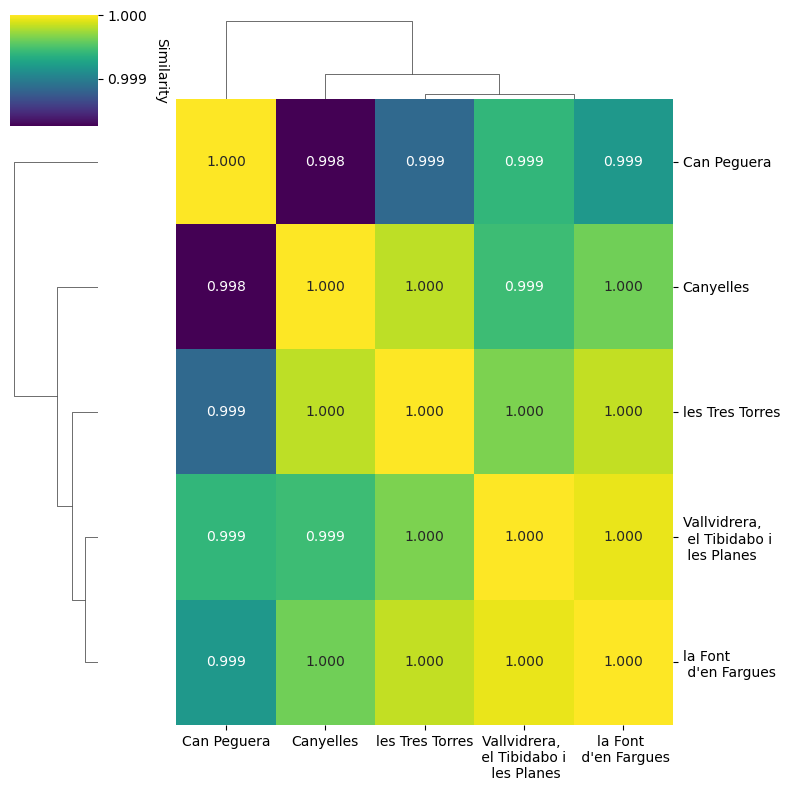

In [41]:
# Readability improvements

cos_sim_df_short = cos_sim_df.copy()
cos_sim_df_short.columns = ['Can Peguera', 'Vallvidrera, \n el Tibidabo i \n les Planes', 'les Tres Torres', 'la Font \n d\'en Fargues', 'Canyelles']
cos_sim_df_short.index = ['Can Peguera', 'Vallvidrera, \n el Tibidabo i \n les Planes', 'les Tres Torres', 'la Font \n d\'en Fargues', 'Canyelles']

# Clustermap with adjusted color scale limits

g = sns.clustermap(cos_sim_df_short,
                   annot = True,
                   fmt = '.3f',
                   cmap = 'viridis',
                   center = None,  # Remove center since your data isn't centered around 0
                   vmin = cos_sim_df_short.values.min(),  # Minimum data value
                   vmax = cos_sim_df_short.values.max(),  # Maximum data value
                   figsize = (8, 8),
                   dendrogram_ratio = 0.15,
                   cbar_pos = (0.9, 0.8, 0.03, 0.18))

# Improve label readability

plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha = 'center')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation = 0)

g.ax_row_dendrogram.set_position([0.02, 0.55, 0.01, 0.0])    # [left, bottom, width, height]
g.ax_col_dendrogram.set_position([0.95, 0.9, 0.01, 0.0])     # [left, bottom, width, height]

# Colorbar label

g.ax_cbar.set_ylabel('Similarity', rotation = 270, labelpad = 15)

plt.tight_layout()
plt.show()

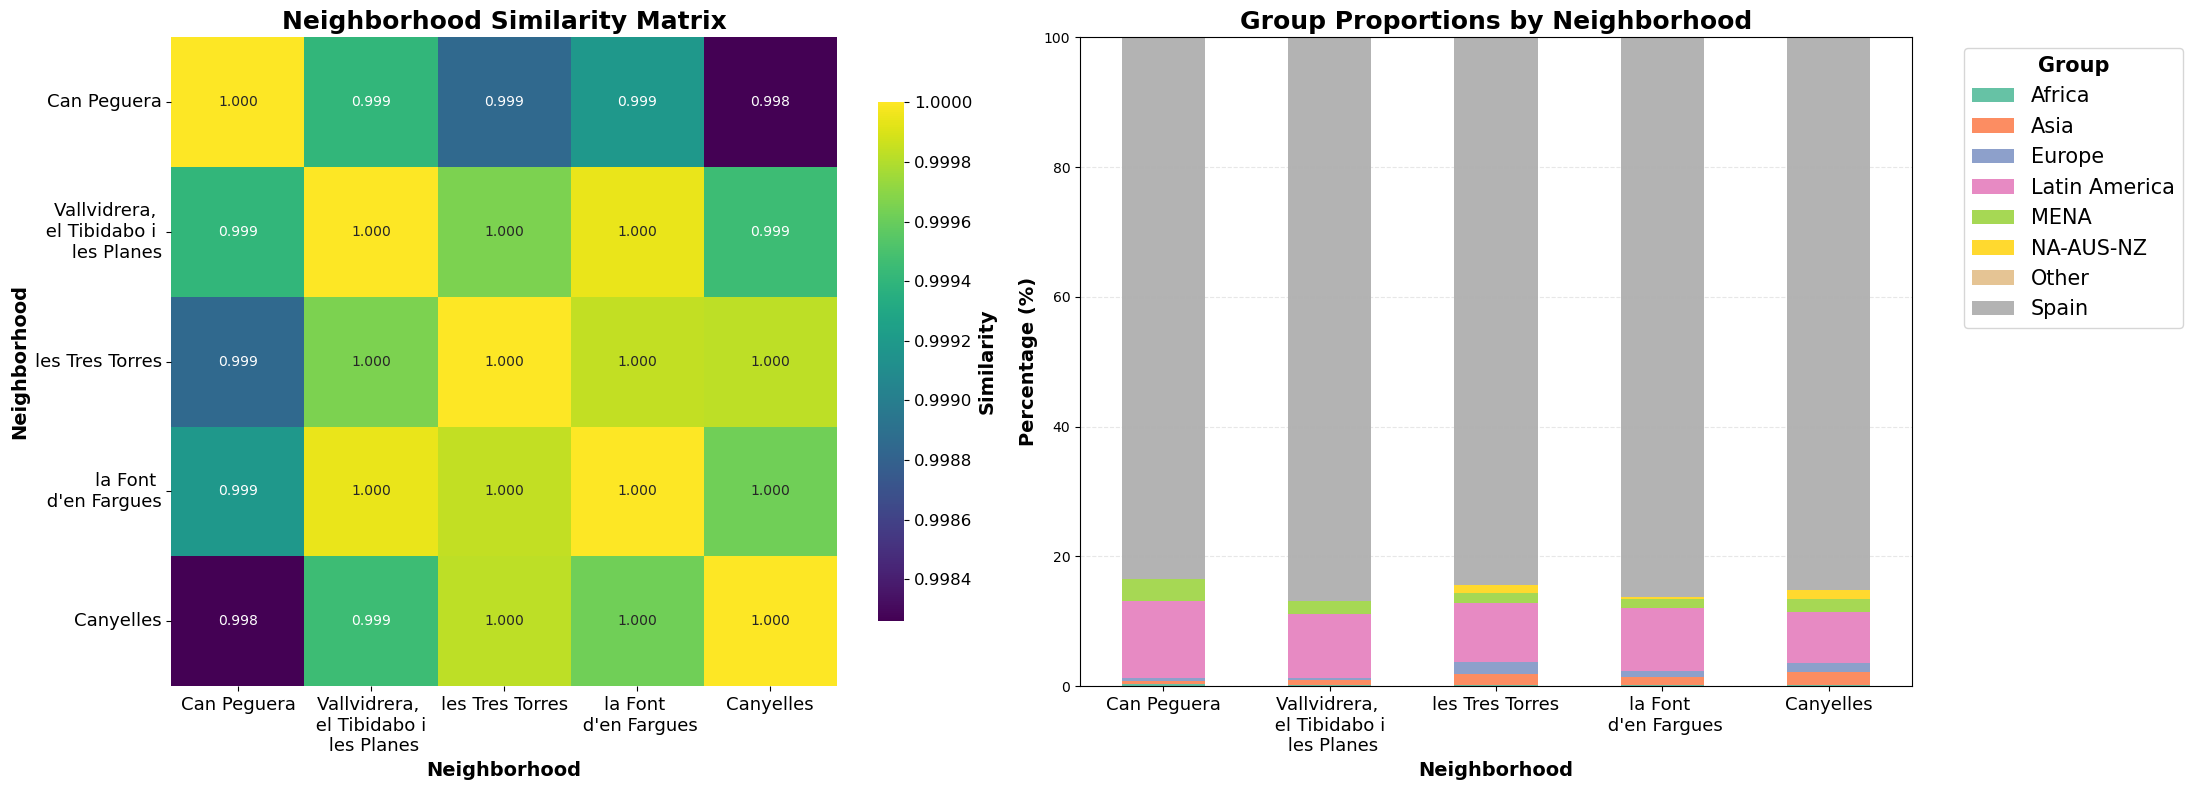

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# --- HEAT MAP (no clustering) --- (clustering complicates the plotting)

## Labels for better readability

cos_sim_df_short = cos_sim_df.copy()
cos_sim_df_short.columns = ['Can Peguera', 'Vallvidrera, \n el Tibidabo i \n les Planes', 'les Tres Torres', 'la Font \n d\'en Fargues', 'Canyelles']
cos_sim_df_short.index = ['Can Peguera', 'Vallvidrera, \n el Tibidabo i \n les Planes', 'les Tres Torres', 'la Font \n d\'en Fargues', 'Canyelles']

## Heatmap

heatmap = sns.heatmap(cos_sim_df_short, 
            annot = True, 
            fmt = '.3f', 
            cmap = 'viridis', 
            vmin = cos_sim_df_short.values.min(),
            vmax = cos_sim_df_short.values.max(),
            ax = ax1,
            cbar_kws = {'label': 'Similarity', 'shrink': 0.8})

## Colorbar

cbar = heatmap.collections[0].colorbar
cbar.set_label('Similarity', size = 14, weight='bold')
cbar.ax.tick_params(labelsize = 12)

## Title

ax1.set_title('Neighborhood Similarity Matrix', fontsize = 18, fontweight = 'bold')

## x-axis labels

ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 0, ha = 'center', fontsize = 13)
ax1.set_xlabel('Neighborhood', fontsize = 14, fontweight = 'bold')

## y-axis labels

ax1.set_yticklabels(ax1.get_yticklabels(), rotation = 0, ha = 'right', fontsize = 13) 
ax1.set_ylabel('Neighborhood', fontsize = 14, fontweight = 'bold')

# --- RIGHT: STACKED BAR CHART ---

## Load data

df = neighborhood_lecture_groups(2025)

filtered_df = df[df['Neighborhood'].isin(neighborhood_selection)]

pivot_df = filtered_df.pivot(index = 'Neighborhood', columns = 'Group', values = 'Value').fillna(0)
percentage_df = pivot_df.div(pivot_df.sum(axis = 1), axis = 0) * 100

## Stacked bar chart

bars = percentage_df.plot(kind = 'bar', stacked = True, ax = ax2, legend = True, cmap = "Set2")

## Title

ax2.set_title('Group Proportions by Neighborhood', fontsize = 18, fontweight = 'bold')
## y-axis labels

ax2.set_ylabel('Percentage (%)', fontsize = 14, fontweight = 'bold')

## x-axis labels

ax2.set_xlabel('Neighborhood', fontsize = 14, fontweight = 'bold')
ax2.set_xticklabels(['Can Peguera', 'Vallvidrera, \n el Tibidabo i \n les Planes', 'les Tres Torres', 'la Font \n d\'en Fargues', 'Canyelles'], 
                   rotation = 0, ha = 'center', fontsize = 13)

## Legend
ax2.legend(title = 'Group', fontsize = 15, bbox_to_anchor = (1.05, 1), loc = 'upper left', title_fontproperties = {'weight': 'bold', 'size': 15})

## Limit y-axis

ax2.set_ylim(0, 100) 

## -

ax2.grid(axis = 'y', alpha = 0.3, linestyle = '--')  
plt.tight_layout()
plt.show()